In [1]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/class_financial-econometrics


In [2]:
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents as UCM
import statsmodels.api as sm

In [3]:
plt.style.use("../styler.mplstyle") 

In [4]:
data = ['GDP', 'USRECQ']

In [5]:
df = pdr.DataReader(
    data,
    "fred",
    start="1954-01-01",
    end="2025-07-01",
).astype(float)

In [6]:

df['GDP_r'] =  100 * np.log(df['GDP']).diff()


In [7]:
df = df.dropna()

In [8]:
def regime_switching_model(df, lags = 4):

    mod = sm.tsa.MarkovRegression(
    df["GDP_r"],
    k_regimes=2,
    trend="c",                
    switching_trend=True,     
    order=lags,                 
    switching_variance=False   
    )
    res = mod.fit(em_iter=80, search_reps=50, disp=False)


    regimes = {k: v for k, v in res.params.items() if 'trend' in k or 'const' in k}
    low_mean_regime = int(np.argmin(list(regimes.values())))

    p_smoothed = res.filtered_marginal_probabilities[low_mean_regime]
    recession_smoothed = p_smoothed.rename("P(recession|T)")

    return mod, res, recession_smoothed


def plot_regime_switching(df, pred_recession, title):

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(pred_recession, label='Recession Probability')

    # Shade areas where USRECQ == 1
    ax.fill_between(
        df.index,
        0, 1,                      # vertical span
        where=df["USRECQ"].astype(bool),
        color='gray',
        alpha=0.3,
        transform=ax.get_xaxis_transform(), 
        label = 'Recessions'
    )

    ax.set_title('Probability of Recession')
    ax.set_ylabel('Probability of Recession')
    ax.set_xlabel('Date')
    ax.legend(loc='upper center', frameon=True)
    plt.savefig(f'../Figures/Assignment07/{title}.png', dpi = 300)
    plt.show()

### Question 1

In [9]:
pre_1984 = df.loc['1952-01-01': '1984-10-01']

In [10]:
pre_1984

,GDP,USRECQ,GDP_r
DATE,,,
1954-04-01,386.121,1.0,0.201175
1954-07-01,390.996,0.0,1.254654
1954-10-01,399.734,0.0,2.210200
1955-01-01,413.073,0.0,3.282501
1955-04-01,421.532,0.0,2.027136
...,...,...,...
1983-10-01,3794.706,0.0,2.820300
1984-01-01,3908.054,0.0,2.943261
1984-04-01,4009.601,0.0,2.565218


In [11]:
mod, res, recession_smoothed = regime_switching_model(pre_1984)

In [12]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  GDP_r   No. Observations:                  123
Model:               MarkovRegression   Log Likelihood                -181.884
Date:                Fri, 14 Nov 2025   AIC                            373.767
Time:                        18:12:47   BIC                            387.828
Sample:                    04-01-1954   HQIC                           379.479
                         - 10-01-1984                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2046      0.865      0.236      0.813      -1.491       1.900
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0852      0.122     17.156      0.000       1.847       2.323
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.9439      0.133      7.079      0.000       0.683       1.205
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6429      0.226      2.845      0.004       0.200       1.086
p[1->0]        0.0322      0.031      1.036      0.300      -0.029       0.093
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

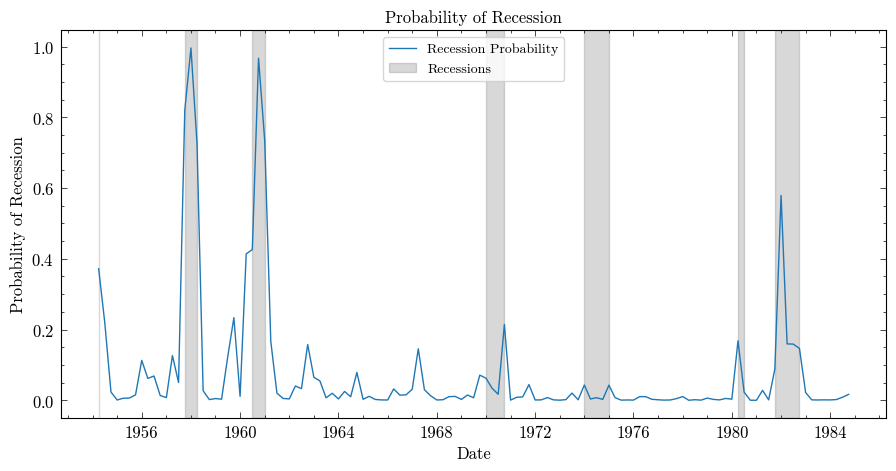

In [13]:
plot_regime_switching(pre_1984, recession_smoothed, '1a')

#### 1.b 

In [14]:
covid  = df.loc[:'2019-10-01']

In [15]:
lags = range(1,10)

In [16]:
aic = []
bic = []
for lag in range(1,10):
    mod = sm.tsa.MarkovRegression(
        covid["GDP_r"],
        k_regimes=2,
        trend="c",                
        switching_trend=True,     
        order=lag,                 
        switching_variance=False   
    )
    res = mod.fit(em_iter=50, search_reps=20, disp=False)
    aic.append(res.aic)
    bic.append(res.bic)

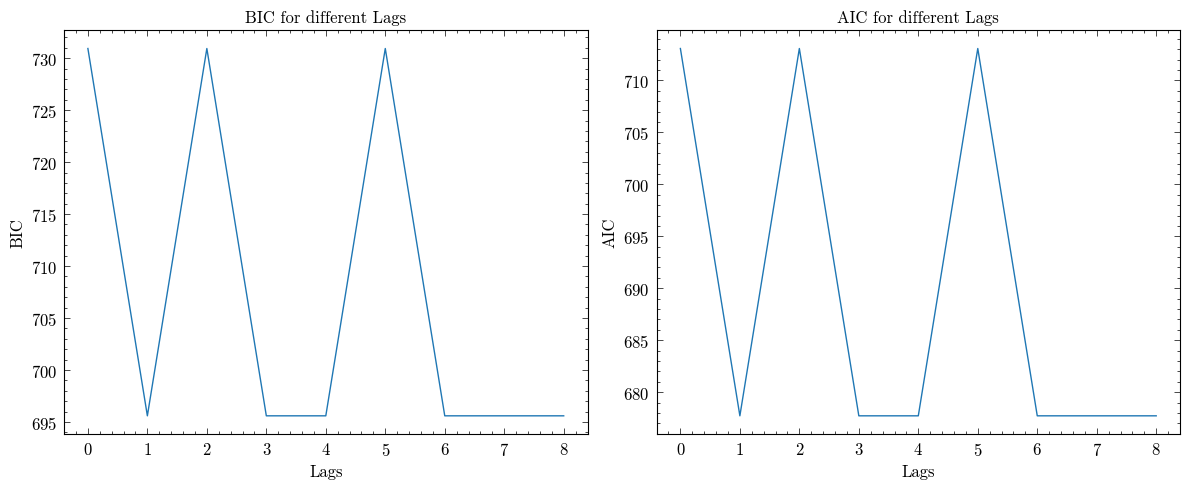

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- BIC subplot ---
axes[0].plot(bic)
axes[0].set_title("BIC for different Lags")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("BIC")

# --- AIC subplot ---
axes[1].plot(aic)
axes[1].set_title("AIC for different Lags")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("AIC")

plt.tight_layout()
plt.savefig('../Figures/Assignment07/1b_aic.png', dpi = 300)

In [18]:
mod, res, recession_smoothed = regime_switching_model(covid, lags=1)

In [19]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  GDP_r   No. Observations:                  263
Model:               MarkovRegression   Log Likelihood                -351.536
Date:                Fri, 14 Nov 2025   AIC                            713.071
Time:                        18:12:50   BIC                            730.932
Sample:                    04-01-1954   HQIC                           720.249
                         - 10-01-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5382      0.659     -0.817      0.414      -1.829       0.753
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6106      0.060     26.731      0.000       1.492       1.729
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7602      0.070     10.908      0.000       0.624       0.897
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.6636      0.199      3.336      0.001       0.274       1.053
p[1->0]        0.0119      0.009      1.355      0.175      -0.005       0.029
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

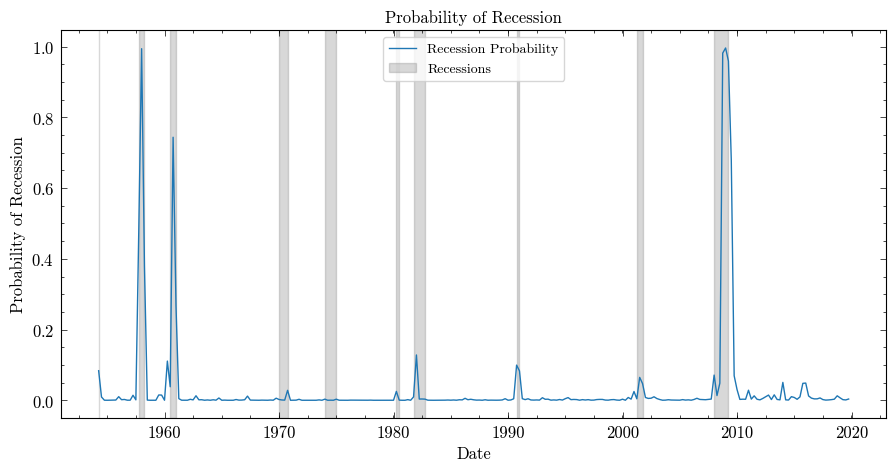

In [20]:
plot_regime_switching(covid, recession_smoothed, '1b')

#### 1.C

In [21]:
aic = []
bic = []
for lag in range(1,10):
    mod = sm.tsa.MarkovRegression(
        df["GDP_r"],
        k_regimes=2,
        trend="c",                
        switching_trend=True,     
        order=lag,                 
        switching_variance=False   
    )
    res = mod.fit(em_iter=50, search_reps=20, disp=False)
    aic.append(res.aic)
    bic.append(res.bic)

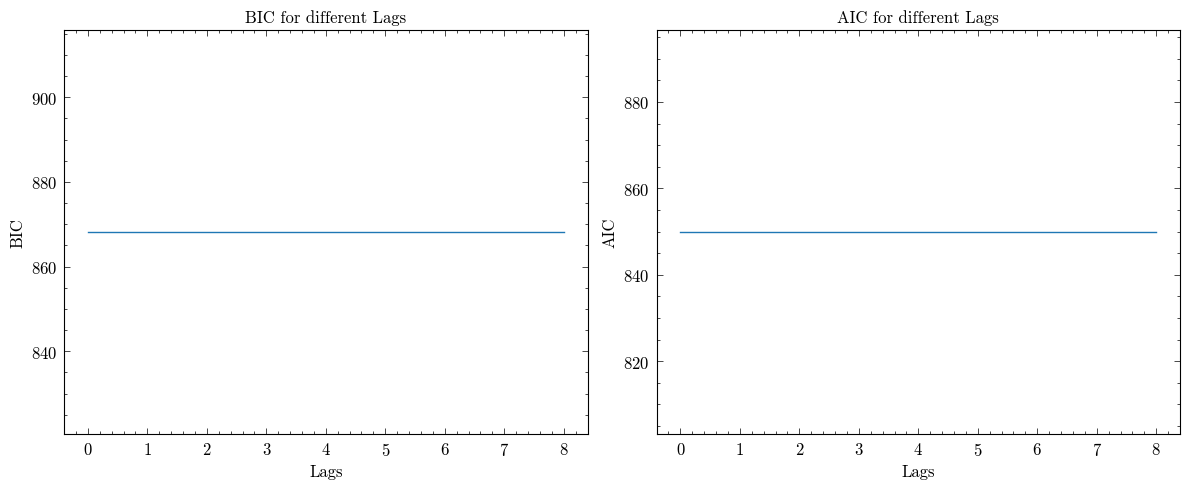

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- BIC subplot ---
axes[0].plot(bic)
axes[0].set_title("BIC for different Lags")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("BIC")

# --- AIC subplot ---
axes[1].plot(aic)
axes[1].set_title("AIC for different Lags")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("AIC")

plt.tight_layout()
plt.savefig('../Figures/Assignment07/1c_aic.png', dpi = 300)

In [23]:
mod, res, recession_smoothed = regime_switching_model(df, lags=1)

In [24]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  GDP_r   No. Observations:                  285
Model:               MarkovRegression   Log Likelihood                -419.935
Date:                Fri, 14 Nov 2025   AIC                            849.870
Time:                        18:12:51   BIC                            868.133
Sample:                    04-01-1954   HQIC                           857.191
                         - 04-01-2025                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6026      1.032     -8.338      0.000     -10.625      -6.581
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5693      0.061     25.635      0.000       1.449       1.689
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0644      0.089     11.937      0.000       0.890       1.239
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]     7.311e-32        nan        nan        nan         nan         nan
p[1->0]        0.0035      0.004      1.002      0.316      -0.003       0.010
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

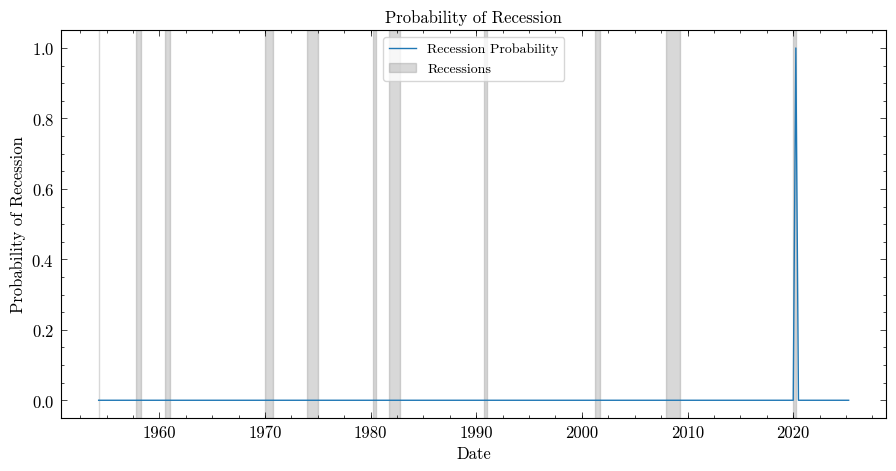

In [25]:
plot_regime_switching(df, recession_smoothed, '1c')


### Question 3

In [26]:
data_2 = ["TB3MS", "CPIAUCSL"]

In [27]:
df_2 = pdr.DataReader(
    data_2,
    "fred",
    start="1954-01-01",
    end="2025-07-01",
).astype(float)

In [28]:
df_2.resample("Q").mean()

/tmp/ipykernel_78034/2239865339.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df_2.resample("Q").mean()


,TB3MS,CPIAUCSL
DATE,,
1954-03-31,1.060000,26.953333
1954-06-30,0.790000,26.910000
1954-09-30,0.883333,26.840000
1954-12-31,1.020000,26.756667
1955-03-31,1.223333,26.793333
...,...,...
2024-09-30,4.990000,314.182667
2024-12-31,4.400000,316.538667
2025-03-31,4.210000,319.492000


In [29]:
df_2['INF'] = 400 * np.log(df_2['CPIAUCSL']/ df_2['CPIAUCSL'].shift(-1))
# df_2['INF_demeaned'] = df_2['INF'] - df_2['INF'].mean()

In [30]:
df_2

,TB3MS,CPIAUCSL,INF
DATE,,,
1954-01-01,1.18,26.940,-0.741702
1954-02-01,0.97,26.990,0.890208
1954-03-01,1.03,26.930,1.041086
1954-04-01,0.97,26.860,-1.041086
1954-05-01,0.76,26.930,-0.148506
...,...,...,...
2025-03-01,4.20,319.615,-0.882589
2025-04-01,4.21,320.321,-0.323295
2025-05-01,4.25,320.580,-1.146275


In [31]:
df_2 = df_2.loc[:"2007-10-01"]

In [32]:
for L in range(1,4):
    df_2[f"INF_l{L}"] = df_2["INF"].shift(L)

/tmp/ipykernel_78034/1306955963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[f"INF_l{L}"] = df_2["INF"].shift(L)
/tmp/ipykernel_78034/1306955963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2[f"INF_l{L}"] = df_2["INF"].shift(L)
/tmp/ipykernel_78034/1306955963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [33]:
df_2.dropna(inplace=True)

/tmp/ipykernel_78034/600093465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.dropna(inplace=True)


In [34]:
y = df_2["TB3MS"]
X = df_2[["INF", "INF_l1", "INF_l2", "INF_l3"]]

In [35]:
mod = sm.tsa.MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    trend="c",                   # common intercept
    switching_trend=False,       # intercept NOT switching
    switching_exog=True,         # inflation slopes switch by regime
    switching_variance=False     # same variance across regimes
)


res = mod.fit(em_iter=80, search_reps=100, disp=False)
print(res.summary())

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                  TB3MS   No. Observations:                  643
Model:               MarkovRegression   Log Likelihood               -1288.618
Date:                Fri, 14 Nov 2025   AIC                           2601.236
Time:                        18:12:52   BIC                           2654.829
Sample:                    04-01-1954   HQIC                          2622.034
                         - 10-01-2007                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2688      0.149      1.810      0.070      -0.022       0.560
x2             0.1537      0.159      0.966      0.3

In [36]:
regimes = {k: v for k, v in res.params.items() if 'trend' in k or 'const' in k}
p_hawkish = res.smoothed_marginal_probabilities[1]
regimes


{'const[1]': 3.468545419895972}

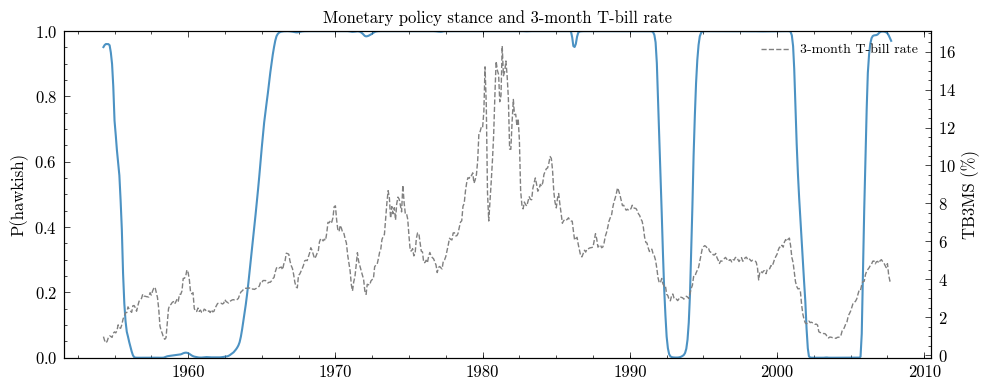

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(df_2.index, p_hawkish, lw=1.5, label='P(hawkish)', alpha=0.8)
# ax1.fill_between(df_2.index, 0, p_hawkish, alpha=0.3)
ax1.set_ylim(0, 1)
ax1.set_ylabel('P(hawkish)')
ax1.set_title('Monetary policy stance and 3-month T-bill rate')

# right axis: TB3MS
ax2 = ax1.twinx()
ax2.plot(df_2.index, y, lw=1, label='3-month T-bill rate', linestyle='--', color='grey')
ax2.set_ylabel('TB3MS (%)')

fig.tight_layout()
plt.legend()
plt.savefig(f'../Figures/Assignment07/2c.png', dpi = 300)
plt.show()